 # ML for Environmental Engineering 
 By: Suheyla Tozan and Steven Gutterman

## Module Import

In [ ]:
!pip install openpyxl
!pip install tensorflow
!pip install hyperopt
!pip install pandas
!pip install matplotlib
!pip install xarray
!pip install seaborn
!pip install scikit-learn
!pip install utils
!pip install keras
!pip install --upgrade tensorflow

In [ ]:
!pip install xgboost==1.7.6


In [1]:
# Import Modules
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import *

xgboost version =  2.0.2


## Data Processing

/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_20810/1828264225.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_20810/1828264225.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
/var/folders/93/5t7_3xxn2dvdtnjj99wxz2wc0000gn/T/ipykernel_20810/1828264225.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

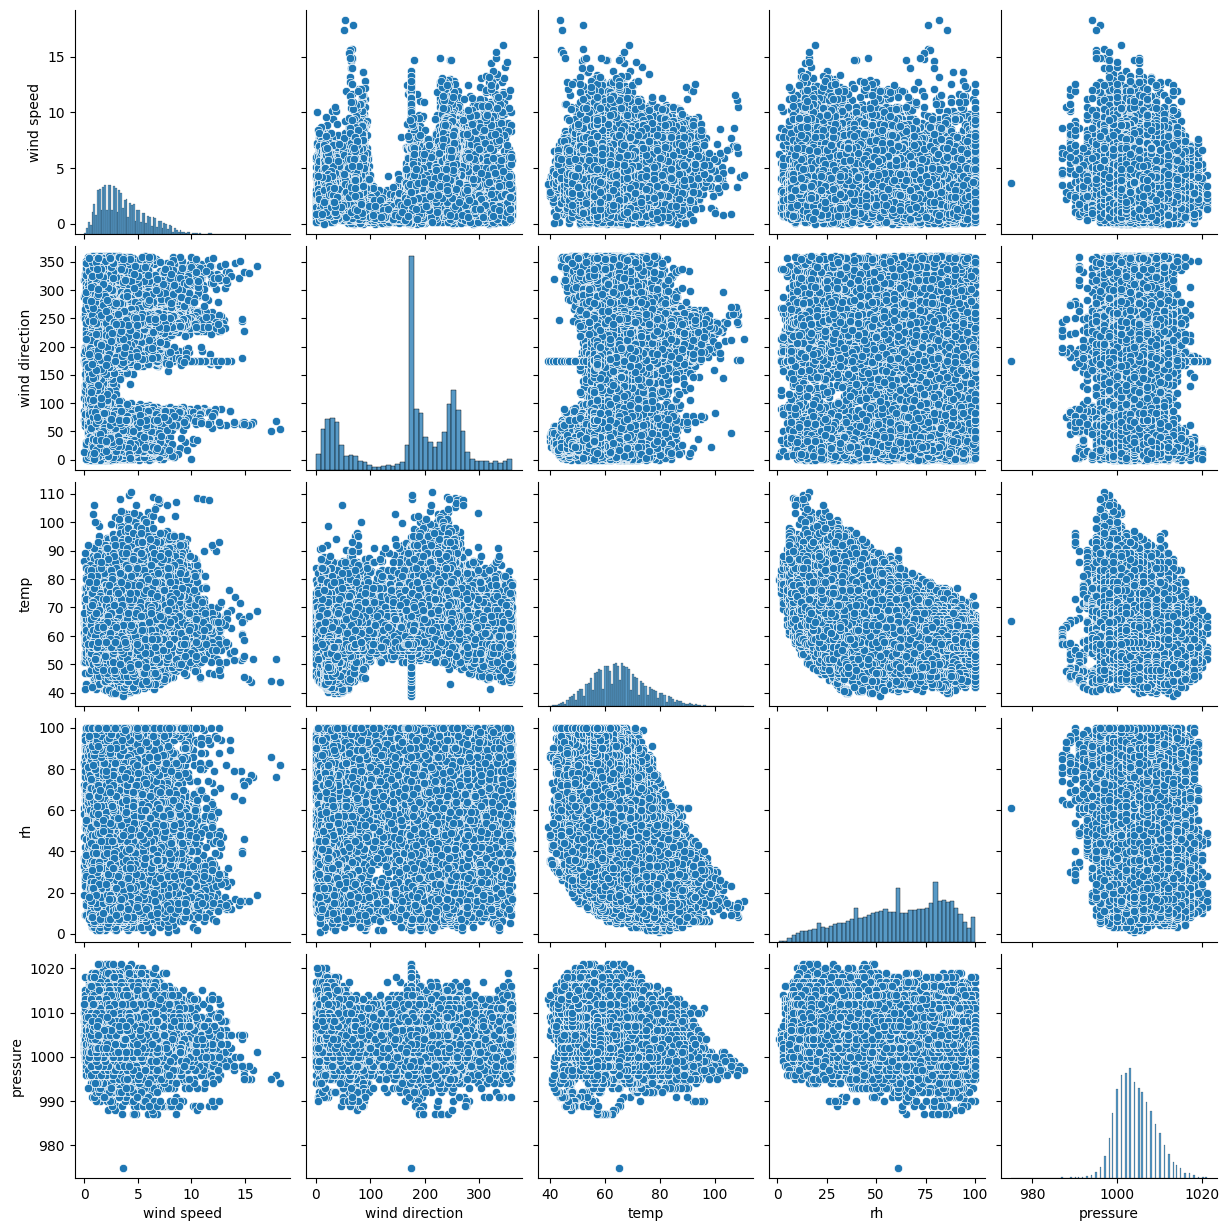

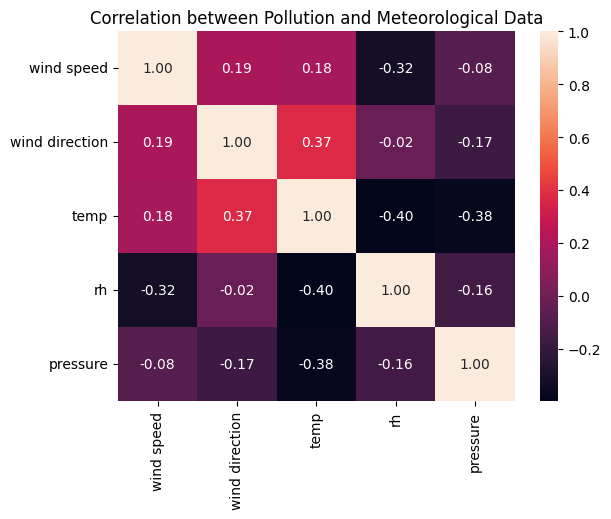

In [111]:
# 1. Data Processing: Prepare Data for Training & Testing

df = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx") #meterological data
df2 = pd.read_excel("Data/criteriagasdata_2018-2023_ELABHWC.xlsx") #air quality data


merged_df = pd.merge(df, df2, on=['date_gmt', 'time_gmt'], how='inner')
desired_columns = ['date_gmt', 'time_gmt', 'wind speed', 'wind direction', 'temp', 'rh', 'pressure', 'CO', 'NO2', 'SO2','O3','PM10']
final_df = merged_df[desired_columns]
co_original = final_df['CO']
no2_original = final_df['NO2']
so2_original = final_df['SO2']
o3_original = final_df['O3']
#Get rid of all predictand data that is 'NaN'
df_new = final_df.dropna(subset=['CO', 'NO2', 'SO2','O3'])

df_new.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
df_new.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
df_new.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
df_new.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
df_new.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

X_features = df_new[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
y_co = df_new['CO']
y_no2 = df_new['NO2']
y_so2 = df_new['SO2']
y_o3 = df_new['O3']

#Pairplot
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
sns.pairplot(subset_corr)
plt.savefig("pairplot.png")
plt.show()

#Heatmap
df_cor = df_new.drop(['date_gmt', 'time_gmt'], axis=1)
features = ['wind speed', 'wind direction', 'temp','rh','pressure']
subset_corr = df_cor[features]
correlation_matrix = subset_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation between Pollution and Meteorological Data")
plt.savefig("heatmap.png")
plt.show()


#Determine Train and Test Data

#CO
X_train_co,X_test_co,y_train_co,y_test_co = train_test_split(X_features, y_co, test_size = 0.30, random_state = 512)
X_train_co = X_train_co[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_co = X_test_co['date_gmt']
X_test_co = X_test_co [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#NO2
X_train_no2,X_test_no2,y_train_no2,y_test_no2 = train_test_split(X_features, y_no2, test_size = 0.30, random_state = 512)
X_train_no2 = X_train_no2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_no2 = X_test_no2['date_gmt']
X_test_no2 = X_test_no2 [['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#SO2
X_train_so2,X_test_so2,y_train_so2,y_test_so2 = train_test_split(X_features, y_so2, test_size = 0.30, random_state = 512)
X_train_so2 = X_train_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_so2 = X_test_so2['date_gmt']
X_test_so2 = X_test_so2[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]

#O3
X_train_o3,X_test_o3,y_train_o3,y_test_o3 = train_test_split(X_features, y_o3, test_size = 0.30, random_state = 512)
X_train_o3 = X_train_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
time_test_o3 = X_test_o3['date_gmt']
X_test_o3 = X_test_o3[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]


# Standardization
mean_co, std_co = X_train_co.mean(), X_train_co.std()
mean_no2, std_no2 = X_train_no2.mean(), X_train_no2.std()
mean_so2, std_so2 = X_train_so2.mean(), X_train_so2.std()
mean_o3, std_o3 = X_train_o3.mean(), X_train_o3.std()

#CO
X_train_co = (X_train_co - mean_co)/std_co
X_test_co = (X_test_co - mean_co)/std_co
#NO2
X_train_no2 = (X_train_no2 - mean_no2)/std_no2
X_test_no2 = (X_test_no2 - mean_no2)/std_no2
#SO2
X_train_so2 = (X_train_so2 - mean_so2)/std_so2
X_test_so2 = (X_test_so2 - mean_so2)/std_so2
#O3
X_train_o3 = (X_train_o3 - mean_o3)/std_o3
X_test_o3 = (X_test_o3 - mean_o3)/std_o3

X_train_fi_co = pd.DataFrame(X_train_co, columns=features)
X_train_co = X_train_co.to_numpy()
y_train_co = y_train_co.to_numpy()
X_test_co = X_test_co.to_numpy()

X_train_fi_no2 = pd.DataFrame(X_train_no2, columns=features)
X_train_no2 = X_train_no2.to_numpy()
y_train_no2 = y_train_no2.to_numpy()
X_test_no2 = X_test_no2.to_numpy()

X_train_fi_so2 = pd.DataFrame(X_train_so2, columns=features)
X_train_so2 = X_train_so2.to_numpy()
y_train_so2 = y_train_so2.to_numpy()
X_test_so2 = X_test_so2.to_numpy()

X_train_fi_o3 = pd.DataFrame(X_train_o3, columns=features)
X_train_o3 = X_train_o3.to_numpy()
y_train_o3 = y_train_o3.to_numpy()
X_test_o3 = X_test_o3.to_numpy()

## Function for Model Evaluation

In [112]:
#Feature Importance
# The code below was retained from the following website with slight modifications: 
#https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

def plot_feature_importance(importance,names, model, gas):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(6,6))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model}: {gas} Concentration Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

#Prediction Error Histogram
def prediction_error(outcome, input, model, gas):
    errors = outcome - input
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.5)
    plt.title(f'{model}: {gas} Concentration Model Evlaution')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

## CO Model Building

In [ ]:
#CO
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering: 
# Random Forest Lecture

#Start cross validation for optimization
# Number of trees in random forest 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,30, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg0 = RandomForestRegressor(random_state=0)
# perform cross-validation
rf_random01 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_co = rf_random01.fit(X_train_co,y_train_co)

print("The best hyperparameters: \n",rf_co.best_params_)

y_test_copre = rf_co.predict(X_test_co)
y_train_copre = rf_co.predict(X_train_co)


In [113]:
# Best model based on hyperparameter tuning
n_estimators      = 100    # Number of trees in random forest
min_samples_split = 5    # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = 'log2'   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = 25     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_co = reg0.fit(X_train_co,y_train_co)
y_test_copre = rf_co.predict(X_test_co)
y_train_copre = rf_co.predict(X_train_co)

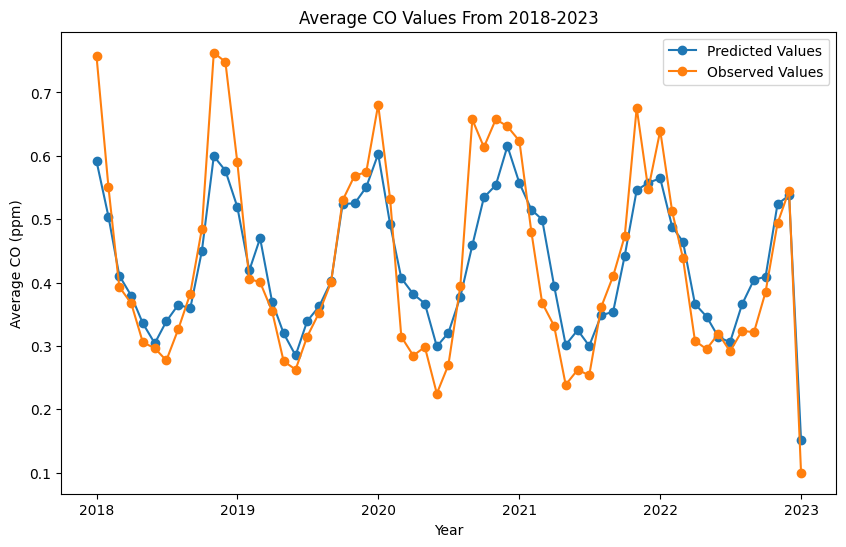

Test Mean Squared Error: 0.03628234617916042
Train Mean Squared Error: 0.01942177867739314
Test Root Mean Squared Error: 0.1904792539337563
Train Root Mean Squared Error: 0.1393620417380326
Test Mean Absolute Error: 0.12886867187855722
Train Mean Absolute Error: 0.09266098638939468
0.7983704245470888


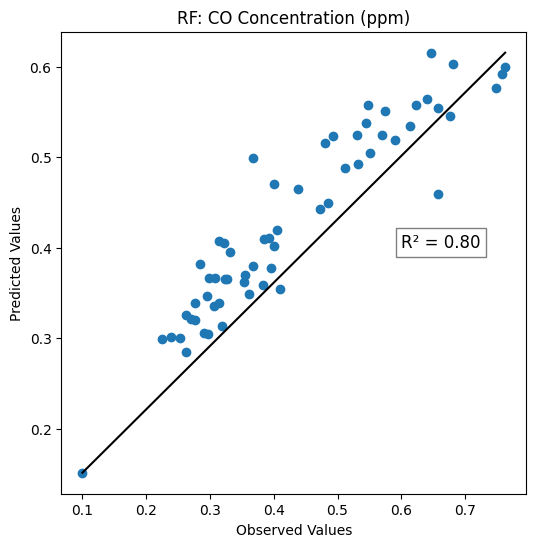

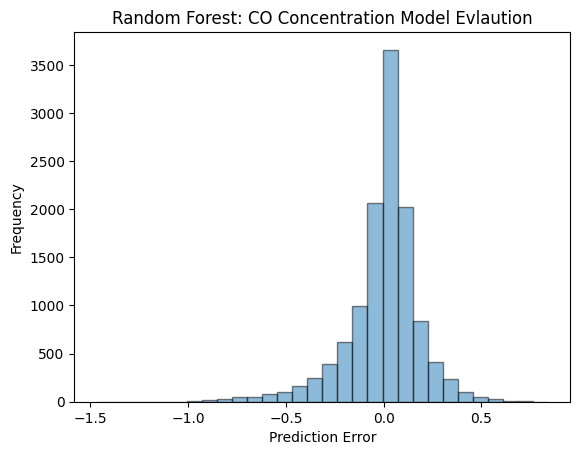

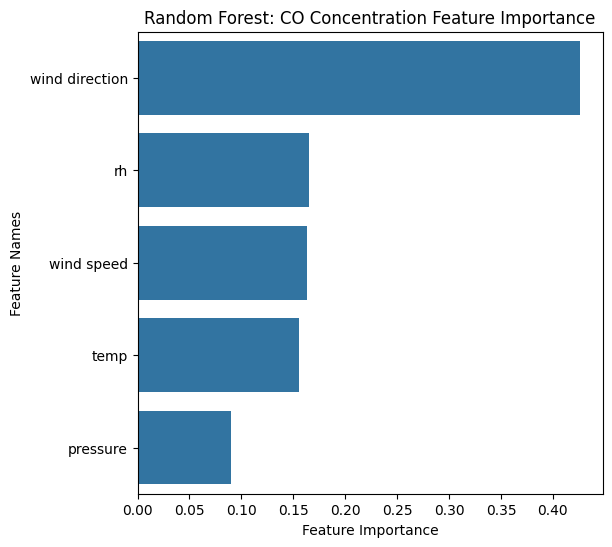

In [114]:
# CO
# Organize data into monthly averages and plot
y_test_copre = pd.Series(y_test_copre)
y_test_copre = y_test_copre.reset_index(drop=True)
time_test_co = time_test_co.reset_index(drop=True)
co_df  = pd.concat([y_test_copre, time_test_co], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

# Extract year and month into new columns
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df1 = average_values.reset_index()

#Repeat all above for observed data
y_test_co = pd.Series(y_test_co)
y_test_co = y_test_co.reset_index(drop=True)
co_test_df = pd.concat([y_test_co, time_test_co], axis=1)
co_test_df.columns = ['CO', 'Date']
co_test_df['Date'] = pd.to_datetime(co_test_df['Date'])

# Extract year and month into new columns
co_test_df['Year'] = co_test_df['Date'].dt.year
co_test_df['Month'] = co_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
average_values1 = co_test_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df2 = average_values1.reset_index()

#Change the series values to dataframes.
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(average_values_df1['Date'], average_values_df1['CO'], marker='o', label="Predicted Values")  
plt.plot(average_values_df2['Date'], average_values_df2['CO'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average CO Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average CO (ppm)')
plt.legend()
plt.show()

mse_co_test = mean_squared_error(y_test_co, y_test_copre)
print("Test Mean Squared Error:", mse_co_test)
mse_co_train = mean_squared_error(y_train_co, y_train_copre)
print("Train Mean Squared Error:", mse_co_train)

rmse_co_test = mean_squared_error(y_test_co, y_test_copre, squared=False)
print(f"Test Root Mean Squared Error: {rmse_co_test}")
rmse_co_train = mean_squared_error(y_train_co, y_train_copre, squared=False)
print(f"Train Root Mean Squared Error: {rmse_co_train}")


mae_co_test = mean_absolute_error(y_test_co, y_test_copre)
print(f"Test Mean Absolute Error: {mae_co_test}")
mae_co_train = mean_absolute_error(y_train_co, y_train_copre)
print(f"Train Mean Absolute Error: {mae_co_train}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(average_values_df2['CO'], average_values_df1['CO'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(average_values_df2['CO'], average_values_df1['CO'])
plt.plot([average_values_df2['CO'].min(), average_values_df2['CO'].max()], [average_values_df1['CO'].min(), average_values_df1['CO'].max()], 'k-')  
plt.title(f'RF: CO Concentration (ppm)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.4 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

   
#Error Prediction Histogram
prediction_error(y_test_copre, y_test_co, 'Random Forest','CO')

# #Feature Importance
#rf_model_co = rf_co.best_estimator_
rf_model_co = rf_co
plot_feature_importance(rf_model_co.feature_importances_, X_train_fi_co.columns, 'Random Forest','CO')

## NO2 Model Building

In [ ]:
#NO2
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering: 
# Random Forest Lecture
#Start cross validation for optimization
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg0 = RandomForestRegressor(random_state=0)
# perform cross-validation
rf_random02 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_no2 = rf_random02.fit(X_train_no2,y_train_no2)

print("The best hyperparameters: \n",rf_no2.best_params_)

y_test_no2pre = rf_no2.predict(X_test_no2)
y_train_no2pre = rf_no2.predict(X_train_no2)

In [115]:
# Best model based on hyperparameter tuning
n_estimators      = 175    # Number of trees in random forest
min_samples_split = 5    # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = 'sqrt'   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = 50     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg02 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_no2 = reg02.fit(X_train_no2,y_train_no2)
y_test_no2pre = rf_no2.predict(X_test_no2)
y_train_no2pre = rf_no2.predict(X_train_no2)

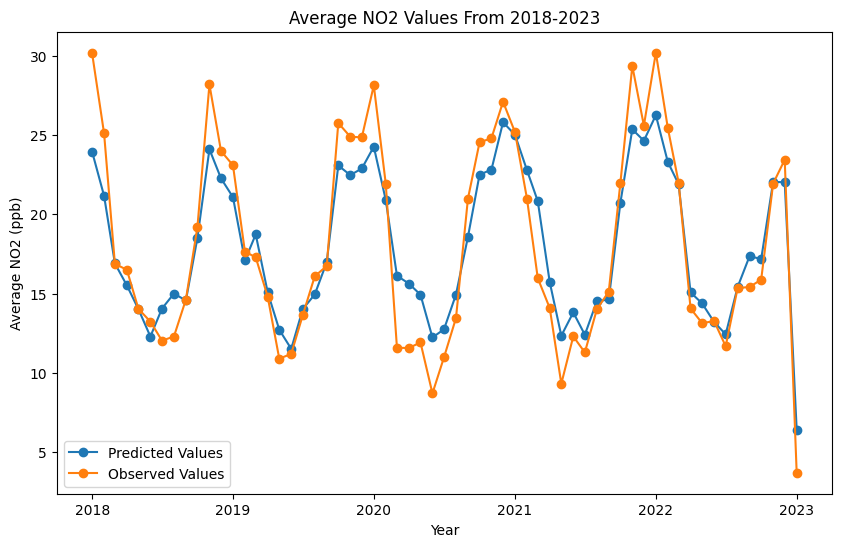

Test Mean Squared Error: 57.70429775558769
Train Mean Squared Error: 31.087002027828767
Test Root Mean Squared Error: 7.596334494714387
Train Root Mean Squared Error: 5.575571901413232
Test Mean Absolute Error: 5.492828463226134
Train Mean Absolute Error: 3.9732720497415146
0.8704012084910063


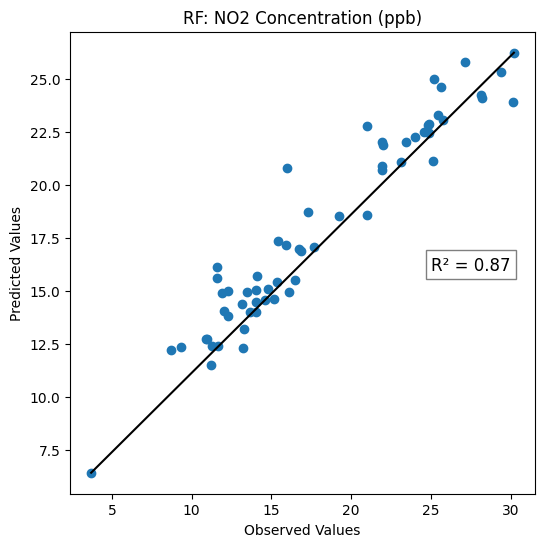

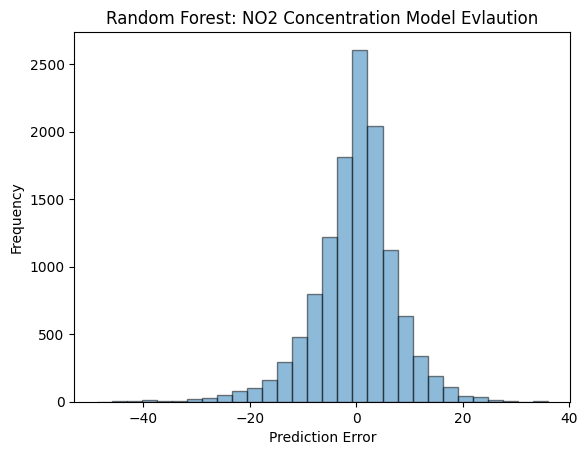

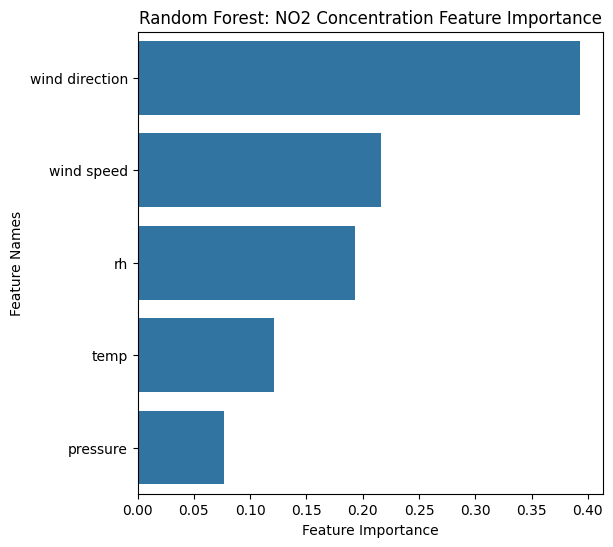

In [116]:
# NO2

# Organize data into monthly averages and plot
y_test_no2pre = pd.Series(y_test_no2pre)
y_test_no2pre = y_test_no2pre.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_df  = pd.concat([y_test_no2pre, time_test_no2], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

# Extract year and month into new columns
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df1 = no2_average_values.reset_index()

#Repeat all above for observed data
y_test_no2 = pd.Series(y_test_no2)
y_test_no2 = y_test_no2.reset_index(drop=True)
time_test_no2 = time_test_no2.reset_index(drop=True)
no2_test_df = pd.concat([y_test_no2, time_test_no2], axis=1)
no2_test_df.columns = ['NO2', 'Date']
no2_test_df['Date'] = pd.to_datetime(no2_test_df['Date'])

# Extract year and month into new columns
no2_test_df['Year'] = no2_test_df['Date'].dt.year
no2_test_df['Month'] = no2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
no2_average_values1 = no2_test_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_average_values_df2 = no2_average_values1.reset_index()

#Change the series values to dataframes.
no2_average_values_df1['Date'] = pd.to_datetime(no2_average_values_df1['Year'].astype(str) + '-' + no2_average_values_df1['Month'].astype(str))
no2_average_values_df2['Date'] = pd.to_datetime(no2_average_values_df2['Year'].astype(str) + '-' + no2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(no2_average_values_df1['Date'], no2_average_values_df1['NO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(no2_average_values_df2['Date'], no2_average_values_df2['NO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average NO2 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average NO2 (ppb)')
plt.legend()
plt.show()

mse_no2_test = mean_squared_error(y_test_no2, y_test_no2pre)
print("Test Mean Squared Error:", mse_no2_test)
mse_no2_train = mean_squared_error(y_train_no2, y_train_no2pre)
print("Train Mean Squared Error:", mse_no2_train)

rmse_no2_test = mean_squared_error(y_test_no2, y_test_no2pre, squared=False)
print(f"Test Root Mean Squared Error: {rmse_no2_test}")
rmse_no2_train = mean_squared_error(y_train_no2, y_train_no2pre, squared=False)
print(f"Train Root Mean Squared Error: {rmse_no2_train}")

mae_no2_test = mean_absolute_error(y_test_no2, y_test_no2pre)
print(f"Test Mean Absolute Error: {mae_no2_test}")
mae_no2_train = mean_absolute_error(y_train_no2, y_train_no2pre)
print(f"Train Mean Absolute Error: {mae_no2_train}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(no2_average_values_df2['NO2'], no2_average_values_df1['NO2'])
plt.plot([no2_average_values_df2['NO2'].min(), no2_average_values_df2['NO2'].max()], [no2_average_values_df1['NO2'].min(), no2_average_values_df1['NO2'].max()], 'k-')  
plt.title(f'RF: NO2 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(25, 16 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_no2pre, y_test_no2, 'Random Forest', 'NO2')


#Feature Importance
#rf_model_no2 = rf_no2.best_estimator_
rf_model_no2 = rf_no2
plot_feature_importance(rf_model_no2.feature_importances_, X_train_fi_no2.columns,'Random Forest', 'NO2')

## SO2 Model Building

In [ ]:
#SO2
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering: 
# Random Forest Lecture

#Start cross validation for optimization
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16, 18]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg0 = RandomForestRegressor(random_state=0)
# perform cross-validation
rf_random03 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_so2 = rf_random03.fit(X_train_so2,y_train_so2)

print("The best hyperparameters: \n",rf_so2.best_params_)

y_test_so2pre = rf_so2.predict(X_test_so2)

In [130]:
# Best model based on hyperparameter tuning
n_estimators      = 233    # Number of trees in random forest
min_samples_split = 15    # Minimum number of samples required to split a node
min_samples_leaf  = 12      # Minimum number of samples required at each leaf node
max_features      = 'sqrt'   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = 10     # Maximum number of levels in tree
bootstrap         = False   # Method of selecting samples for training each tree

reg03 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_so2 = reg03.fit(X_train_so2,y_train_so2)
y_test_so2pre = rf_so2.predict(X_test_so2)
y_train_so2pre = rf_so2.predict(X_train_so2)

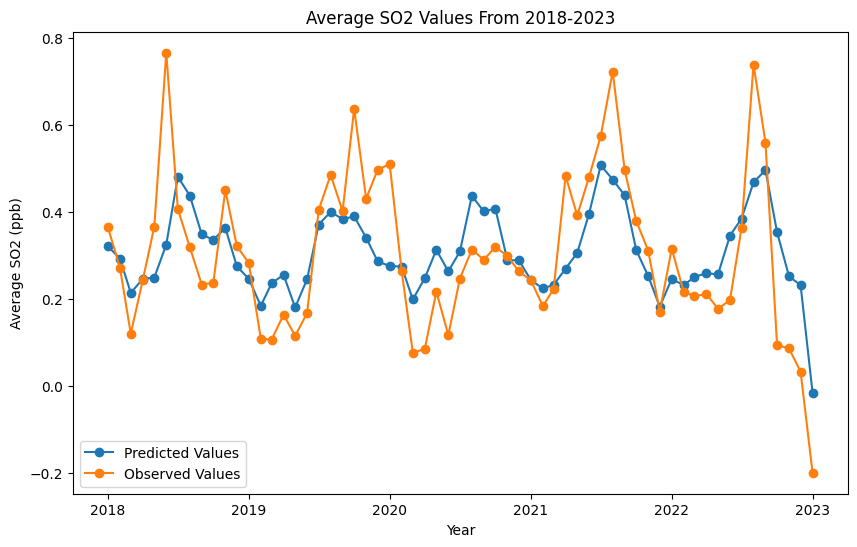

Test Mean Squared Error: 0.061063394439786485
Train Mean Squared Error: 0.06254987191018822
Test Root Mean Squared Error: 0.24711008566990236
Train Root Mean Squared Error: 0.2500997239306518
Test Mean Absolute Error: 0.17132069125698915
Train Mean Absolute Error: 0.16034084217964417
0.48578043167495555


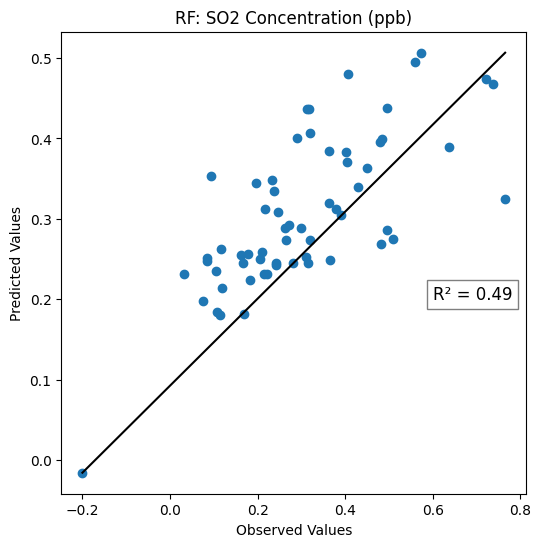

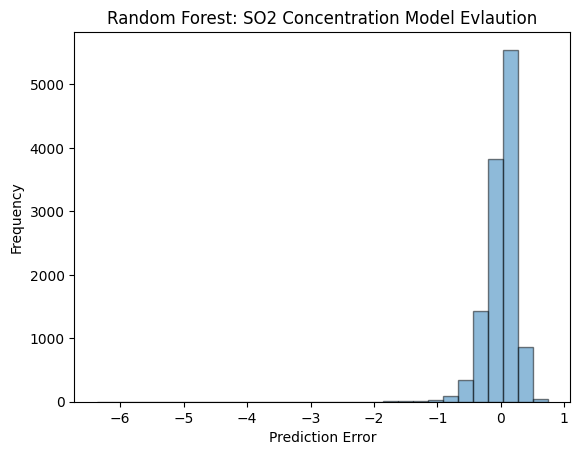

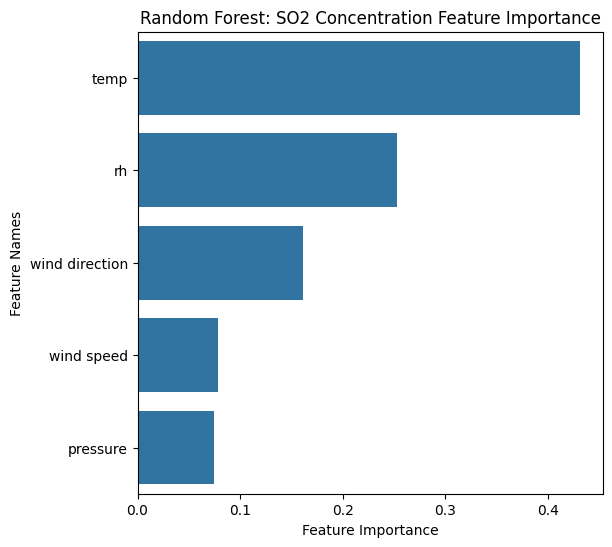

In [131]:
# SO2

# Organize data into monthly averages and plot
y_test_so2pre = pd.Series(y_test_so2pre)
y_test_so2pre = y_test_so2pre.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_df  = pd.concat([y_test_so2pre, time_test_so2], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

# Extract year and month into new columns
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df1 = so2_average_values.reset_index()

#Repeat all above for observed data
y_test_so2 = pd.Series(y_test_so2)
y_test_so2 = y_test_so2.reset_index(drop=True)
time_test_so2 = time_test_so2.reset_index(drop=True)
so2_test_df = pd.concat([y_test_so2, time_test_so2], axis=1)
so2_test_df.columns = ['SO2', 'Date']
so2_test_df['Date'] = pd.to_datetime(so2_test_df['Date'])

# Extract year and month into new columns
so2_test_df['Year'] = so2_test_df['Date'].dt.year
so2_test_df['Month'] = so2_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
so2_average_values1 = so2_test_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_average_values_df2 = so2_average_values1.reset_index()

#Change the series values to dataframes.
so2_average_values_df1['Date'] = pd.to_datetime(so2_average_values_df1['Year'].astype(str) + '-' + so2_average_values_df1['Month'].astype(str))
so2_average_values_df2['Date'] = pd.to_datetime(so2_average_values_df2['Year'].astype(str) + '-' + so2_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(so2_average_values_df1['Date'], so2_average_values_df1['SO2'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(so2_average_values_df2['Date'], so2_average_values_df2['SO2'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average SO2 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average SO2 (ppb)')
plt.legend()
plt.show()

mse_so2_test = mean_squared_error(y_test_so2, y_test_so2pre)
print("Test Mean Squared Error:", mse_so2_test)
mse_so2_train = mean_squared_error(y_train_so2, y_train_so2pre)
print("Train Mean Squared Error:", mse_so2_train)

rmse_so2_test = mean_squared_error(y_test_so2, y_test_so2pre, squared=False)
print(f"Test Root Mean Squared Error: {rmse_so2_test}")
rmse_so2_train = mean_squared_error(y_train_so2, y_train_so2pre, squared=False)
print(f"Train Root Mean Squared Error: {rmse_so2_train}")

mae_so2_test = mean_absolute_error(y_test_so2, y_test_so2pre)
print(f"Test Mean Absolute Error: {mae_so2_test}")
mae_so2_train = mean_absolute_error(y_train_so2, y_train_so2pre)
print(f"Train Mean Absolute Error: {mae_so2_train}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(so2_average_values_df2['SO2'], so2_average_values_df1['SO2'])
plt.plot([so2_average_values_df2['SO2'].min(), so2_average_values_df2['SO2'].max()], [so2_average_values_df1['SO2'].min(), so2_average_values_df1['SO2'].max()], 'k-')  
plt.title(f'RF: SO2 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.6, 0.2 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_so2pre, y_test_so2, 'Random Forest', 'SO2')

#Feature Importance
#rf_model_so2 = rf_so2.best_estimator_
rf_model_so2 = rf_so2
plot_feature_importance(rf_model_so2.feature_importances_, X_train_fi_so2.columns, 'Random Forest','SO2')

## O3 Model Building

In [ ]:
#O3
# The following code has been taken from Professor Pierre Gentine's notes for EAEE 4000 Machine Learning for Environmental Engineering: 
# Random Forest Lecture

#Start cross validation for optimization
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg0 = RandomForestRegressor(random_state=0)
# perform cross-validation
rf_random04 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_o3 = rf_random04.fit(X_train_o3,y_train_o3)

print("The best hyperparameters: \n",rf_o3.best_params_)

y_test_o3pre = rf_o3.predict(X_test_o3)
y_train_o3pre = rf_o3.predict(X_train_o3)

In [119]:
# Best model based on hyperparameter tuning
n_estimators      = 400    # Number of trees in random forest
min_samples_split = 15    # Minimum number of samples required to split a node
min_samples_leaf  = 8      # Minimum number of samples required at each leaf node
max_features      = 'sqrt'   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = 30     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg04 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_o3 = reg04.fit(X_train_o3,y_train_o3)
y_test_o3pre = rf_o3.predict(X_test_o3)
y_train_o3pre = rf_o3.predict(X_train_o3)

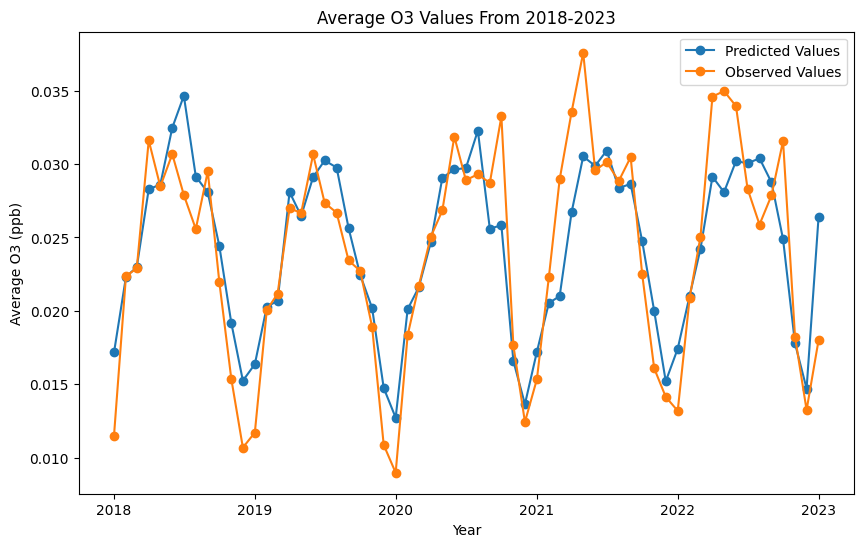

Mean Squared Error: 9.236740958872721e-05
Mean Squared Error: 6.561045678532083e-05
Root Mean Squared Error: 0.009610796511669947
Root Mean Squared Error: 0.008100028196575666
Mean Absolute Error: 0.007307513122483309
Mean Absolute Error: 0.006143604343368371
0.7562779733929944


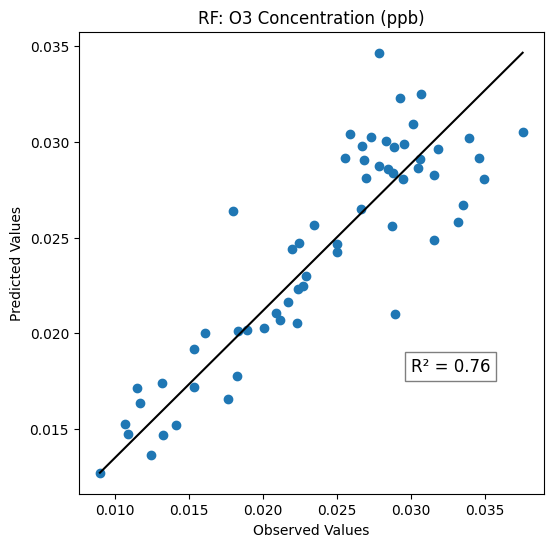

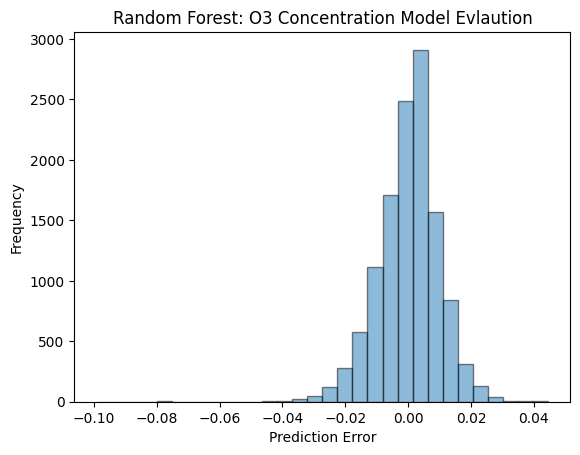

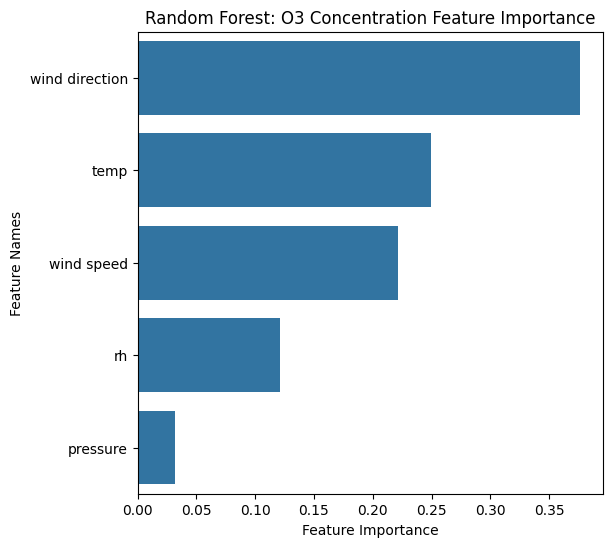

In [120]:
# O3

# Organize data into monthly averages and plot
y_test_o3pre = pd.Series(y_test_o3pre)
y_test_o3pre = y_test_o3pre.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_df  = pd.concat([y_test_o3pre, time_test_o3], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

# Extract year and month into new columns
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df1 = o3_average_values.reset_index()

#Repeat all above for observed data
y_test_o3 = pd.Series(y_test_o3)
y_test_o3 = y_test_o3.reset_index(drop=True)
time_test_o3 = time_test_o3.reset_index(drop=True)
o3_test_df = pd.concat([y_test_o3, time_test_o3], axis=1)
o3_test_df.columns = ['O3', 'Date']
o3_test_df['Date'] = pd.to_datetime(o3_test_df['Date'])

# Extract year and month into new columns
o3_test_df['Year'] = o3_test_df['Date'].dt.year
o3_test_df['Month'] = o3_test_df['Date'].dt.month

# Group by year and month, then calculate the mean of the 'CO' column
o3_average_values1 = o3_test_df.groupby(['Year', 'Month'])['O3'].mean()
o3_average_values_df2 = o3_average_values1.reset_index()

#Change the series values to dataframes.
o3_average_values_df1['Date'] = pd.to_datetime(o3_average_values_df1['Year'].astype(str) + '-' + o3_average_values_df1['Month'].astype(str))
o3_average_values_df2['Date'] = pd.to_datetime(o3_average_values_df2['Year'].astype(str) + '-' + o3_average_values_df2['Month'].astype(str))

# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(o3_average_values_df1['Date'], o3_average_values_df1['O3'], marker='o', label="Predicted Values")  # Create a line plot
plt.plot(o3_average_values_df2['Date'], o3_average_values_df2['O3'], marker='o', label="Observed Values") 

# Adding titles and labels
plt.title('Average O3 Values From 2018-2023')
plt.xlabel('Year')
plt.ylabel('Average O3 (ppb)')
plt.legend()
plt.show()

mse_o3_test = mean_squared_error(y_test_o3, y_test_o3pre)
print("Mean Squared Error:", mse_o3_test)
mse_o3_train = mean_squared_error(y_train_o3, y_train_o3pre)
print("Mean Squared Error:", mse_o3_train)

rmse_o3_test = mean_squared_error(y_test_o3, y_test_o3pre, squared=False)
print(f"Root Mean Squared Error: {rmse_o3_test}")
rmse_o3_train = mean_squared_error(y_train_o3, y_train_o3pre, squared=False)
print(f"Root Mean Squared Error: {rmse_o3_train}")

mae_o3_test = mean_absolute_error(y_test_o3, y_test_o3pre)
print(f"Mean Absolute Error: {mae_o3_test}")
mae_o3_train = mean_absolute_error(y_train_o3, y_train_o3pre)
print(f"Mean Absolute Error: {mae_o3_train}")

#Plot R2 
#The following website was utilize: https://www.geeksforgeeks.org/ml-r-squared-in-regression-analysis/
r2 = r2_score(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
print(r2)
plt.figure(figsize=(6, 6))
plt.scatter(o3_average_values_df2['O3'], o3_average_values_df1['O3'])
plt.plot([o3_average_values_df2['O3'].min(), o3_average_values_df2['O3'].max()], [o3_average_values_df1['O3'].min(), o3_average_values_df1['O3'].max()], 'k-')  
plt.title(f'RF: O3 Concentration (ppb)')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.text(0.030, 0.018 , f'R² = {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#Prediction Error Histogram
prediction_error(y_test_o3pre, y_test_o3, 'Random Forest','O3')

#Feature Importance
#rf_model_o3 = rf_o3.best_estimator_
rf_model_o3 = rf_o3
plot_feature_importance(rf_model_o3.feature_importances_, X_train_fi_o3.columns, 'Random Forest','O3')

## Meteorological Normalization

In [123]:
df_orig = pd.read_excel("Data/metdata_2018-2023_ELABHWC.xlsx")
sum_of_predictions_co, sum_of_predictions_no2 = np.zeros([43789]), np.zeros([43789])
sum_of_predictions_so2, sum_of_predictions_o3 = np.zeros([43789]), np.zeros([43789])
number_of_iterations = 25

for i in range(number_of_iterations):
    df_rand = pd.read_excel(f"Data/random_weather_datasets/output_{i+1}.xlsx")
    
    df_rand['date_gmt'] = df_orig['date_gmt']
    df_rand['time_gmt'] = df_orig['time_gmt']
    
    df_rand.loc[:, 'wind speed'].fillna(df_new['wind speed'].mean(), inplace=True)
    df_rand.loc[:, 'wind direction'].fillna(df_new['wind direction'].mean(), inplace=True)
    df_rand.loc[:, 'temp'].fillna(df_new['temp'].mean(), inplace=True)
    df_rand.loc[:, 'rh'].fillna(df_new['rh'].mean(), inplace=True)
    df_rand.loc[:, 'pressure'].fillna(df_new['pressure'].mean(), inplace=True)

    X = df_rand[['wind speed', 'wind direction', 'temp', 'rh', 'pressure','date_gmt']]
    
    X = X[['wind speed', 'wind direction', 'temp', 'rh', 'pressure']]
    #time_co = X_co['date_gmt']
    
    mean, std = X.mean(), X.std()
    
    X = (X - mean)/std
    
    X = X.to_numpy()
    
    Y_co = rf_co.predict(X)
    sum_of_predictions_co += Y_co

    Y_no2 = rf_no2.predict(X)
    sum_of_predictions_no2 += Y_no2
    
    Y_so2 = rf_so2.predict(X)
    sum_of_predictions_so2 += Y_so2
    
    Y_o3 = rf_o3.predict(X)
    sum_of_predictions_o3 += Y_o3


average_predictions_co = sum_of_predictions_co / number_of_iterations
average_predictions_no2 = sum_of_predictions_no2 / number_of_iterations
average_predictions_so2 = sum_of_predictions_so2 / number_of_iterations
average_predictions_o3 = sum_of_predictions_o3 / number_of_iterations

timeforplot = df_orig['date_gmt']

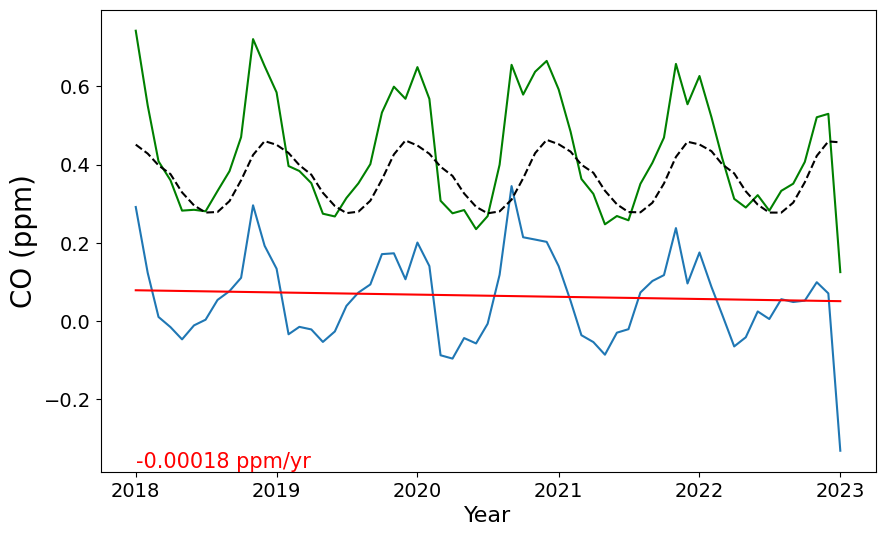

In [154]:
# CO PLOT OF WEATHER NORMALIZATION

weather_norm_co = pd.Series(co_original - average_predictions_co)
y_co = pd.Series(co_original)
weather_prediction_co = pd.Series(average_predictions_co)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
co_df = pd.concat([weather_norm_co, timeforplot], axis=1)
co_df.columns = ['CO', 'Date']
co_df['Date'] = pd.to_datetime(co_df['Date'])

#Group by year and month, then calculate the mean of the 'CO' column
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values_1 = co_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values.reset_index()

co_actual_df = pd.concat([y_co, timeforplot], axis=1)
co_actual_df.columns = ['CO', 'Date']
co_actual_df['Date'] = pd.to_datetime(co_df['Date'])

#Do the same thing for the observed values
co_df['Year'] = co_df['Date'].dt.year
co_df['Month'] = co_df['Date'].dt.month
average_values = co_df.groupby(['Year', 'Month'])['CO'].mean()
co_actual_df['Year'] = co_actual_df['Date'].dt.year
co_actual_df['Month'] = co_actual_df['Date'].dt.month
average_values_2 = co_actual_df.groupby(['Year', 'Month'])['CO'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_co, timeforplot], axis=1)
weather_df.columns = ['CO', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['CO'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['CO'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['CO'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['CO'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['CO']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('CO (ppm)', fontsize=20)  # Increase y-axis label font size
plt.text(x_position, y_position, f'{formatted_slope} ppm/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

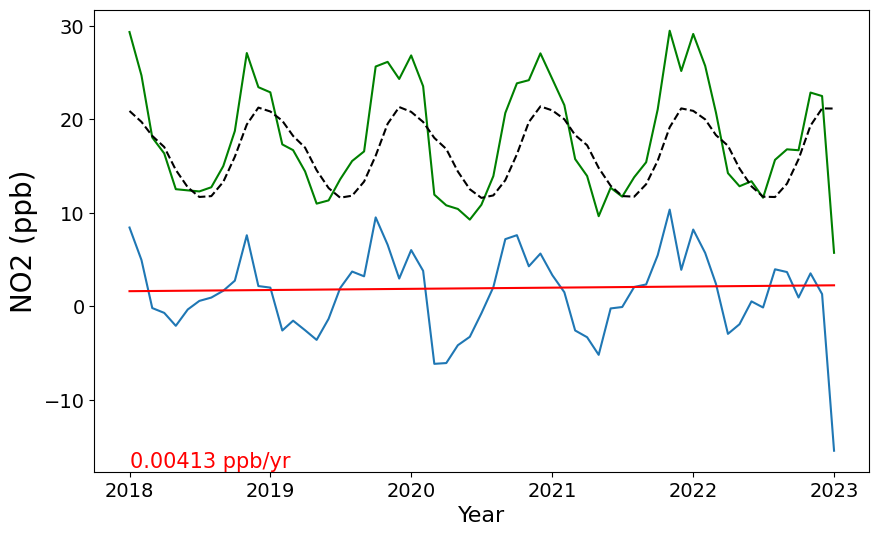

In [155]:
#NO2 PLOT OF WEATHER NORMALIZATION

weather_norm_no2 = pd.Series(no2_original - average_predictions_no2)
y_no2 = pd.Series(no2_original)
weather_prediction_no2 = pd.Series(average_predictions_no2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
no2_df = pd.concat([weather_norm_no2, timeforplot], axis=1)
no2_df.columns = ['NO2', 'Date']
no2_df['Date'] = pd.to_datetime(no2_df['Date'])

no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values_1 = no2_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values.reset_index()

no2_actual_df = pd.concat([y_no2, timeforplot], axis=1)
no2_actual_df.columns = ['NO2', 'Date']
no2_actual_df['Date'] = pd.to_datetime(no2_df['Date'])

#Do the same thing for the observed values
no2_df['Year'] = no2_df['Date'].dt.year
no2_df['Month'] = no2_df['Date'].dt.month
average_values = no2_df.groupby(['Year', 'Month'])['NO2'].mean()
no2_actual_df['Year'] = no2_actual_df['Date'].dt.year
no2_actual_df['Month'] = no2_actual_df['Date'].dt.month
average_values_2 = no2_actual_df.groupby(['Year', 'Month'])['NO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_no2, timeforplot], axis=1)
weather_df.columns = ['NO2', 'Date']
weather_df['Date'] = pd.to_datetime(no2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['NO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['NO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['NO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['NO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['NO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('NO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

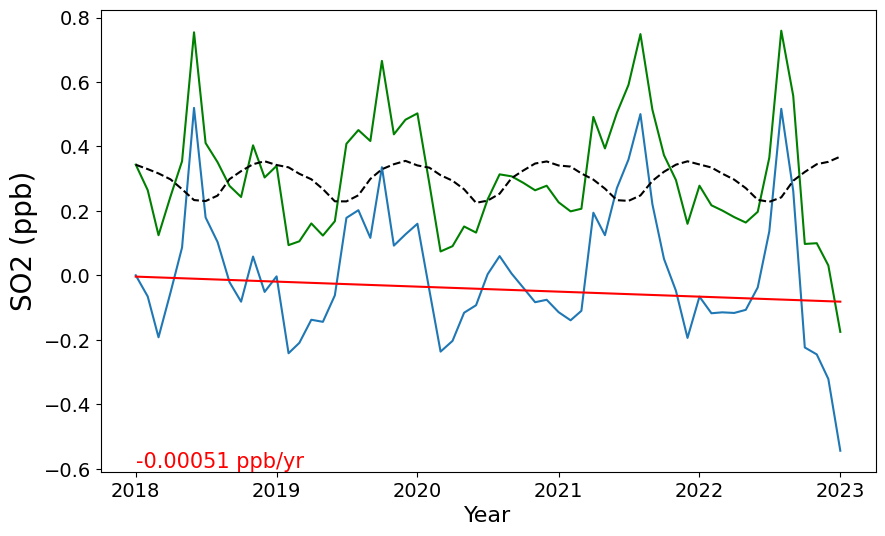

In [156]:
#SO2 PLOT OF WEATHER NORMALIZATION

weather_norm_so2 = pd.Series(so2_original - average_predictions_so2)
y_so2 = pd.Series(so2_original)
weather_prediction_so2 = pd.Series(average_predictions_so2)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
so2_df = pd.concat([weather_norm_so2, timeforplot], axis=1)
so2_df.columns = ['SO2', 'Date']
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values_1 = so2_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values.reset_index()

so2_actual_df = pd.concat([y_so2, timeforplot], axis=1)
so2_actual_df.columns = ['SO2', 'Date']
so2_actual_df['Date'] = pd.to_datetime(so2_df['Date'])

#Do the same thing for the observed values
so2_df['Year'] = so2_df['Date'].dt.year
so2_df['Month'] = so2_df['Date'].dt.month
average_values = so2_df.groupby(['Year', 'Month'])['SO2'].mean()
so2_actual_df['Year'] = so2_actual_df['Date'].dt.year
so2_actual_df['Month'] = so2_actual_df['Date'].dt.month
average_values_2 = so2_actual_df.groupby(['Year', 'Month'])['SO2'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_so2, timeforplot], axis=1)
weather_df.columns = ['SO2', 'Date']
weather_df['Date'] = pd.to_datetime(so2_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['SO2'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['SO2'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['SO2'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['SO2'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['SO2']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('SO2 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()

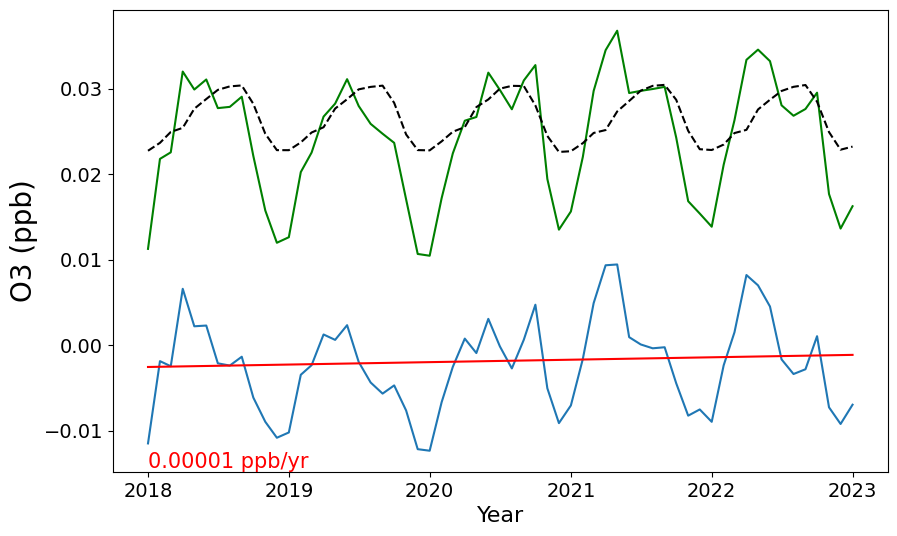

In [157]:
#O3 PLOT OF WEATHER NORMALIZATION

weather_norm_o3 = pd.Series(o3_original - average_predictions_o3)
y_o3 = pd.Series(o3_original)
weather_prediction_o3 = pd.Series(average_predictions_o3)
timeforplot = timeforplot.reset_index(drop=True)

#Create DataFrame for predicted values
o3_df = pd.concat([weather_norm_o3, timeforplot], axis=1)
o3_df.columns = ['O3', 'Date']
o3_df['Date'] = pd.to_datetime(o3_df['Date'])

o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values_1 = o3_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values.reset_index()

o3_actual_df = pd.concat([y_o3, timeforplot], axis=1)
o3_actual_df.columns = ['O3', 'Date']
o3_actual_df['Date'] = pd.to_datetime(o3_df['Date'])

#Do the same thing for the observed values
o3_df['Year'] = o3_df['Date'].dt.year
o3_df['Month'] = o3_df['Date'].dt.month
average_values = o3_df.groupby(['Year', 'Month'])['O3'].mean()
o3_actual_df['Year'] = o3_actual_df['Date'].dt.year
o3_actual_df['Month'] = o3_actual_df['Date'].dt.month
average_values_2 = o3_actual_df.groupby(['Year', 'Month'])['O3'].mean()

average_values_df1 = average_values_1.reset_index()
average_values_df2 = average_values_2.reset_index()


average_values_df1['Year'] = average_values_df1['Year'].astype(int)
average_values_df1['Month'] = average_values_df1['Month'].astype(int)
average_values_df1['Date'] = pd.to_datetime(average_values_df1['Year'].astype(str) + '-' + average_values_df1['Month'].astype(str))

average_values_df2['Year'] = average_values_df2['Year'].astype(int)
average_values_df2['Month'] = average_values_df2['Month'].astype(int)
average_values_df2['Date'] = pd.to_datetime(average_values_df2['Year'].astype(str) + '-' + average_values_df2['Month'].astype(str))

#Now plotting the meteorological average values
weather_df = pd.concat([weather_prediction_o3, timeforplot], axis=1)
weather_df.columns = ['O3', 'Date']
weather_df['Date'] = pd.to_datetime(o3_df['Date'])
weather_df['Year'] = weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.month
average_values_3 = weather_df.groupby(['Year', 'Month'])['O3'].mean()
average_values_df3 = average_values_3.reset_index()
average_values_df3['Year'] = average_values_df3['Year'].astype(int)
average_values_df3['Month'] = average_values_df3['Month'].astype(int)
average_values_df3['Date'] = pd.to_datetime(average_values_df3['Year'].astype(str) + '-' + average_values_df3['Month'].astype(str))

#Plotting
plt.figure(figsize=(10, 6))
plt.plot(average_values_df1['Date'], average_values_df1['O3'], label="Weather Normalized Vals")
plt.plot(average_values_df2['Date'], average_values_df2['O3'], color='g', label="Observed Values")
plt.plot(average_values_df3['Date'], average_values_df3['O3'], linestyle='dashed', color='k', label="met average vals")

#Theil Sen Regression

x_numeric = pd.to_datetime(average_values_df1['Date']).apply(lambda date: date.toordinal())
y = average_values_df1['O3']

#Calculate the slopes between all pairs of points
slopes = [(y[j] - y[i]) / (x_numeric[j] - x_numeric[i]) 
          for i in range(len(average_values_df1)) 
          for j in range(i+1, len(average_values_df1))]

#Calculate median slope
median_slope = np.median(slopes)
annualized_slope = median_slope * 12
formatted_slope = f"{annualized_slope:.5f}"

#Calculate intercepts for each point
intercepts = [y[i] - median_slope * x_numeric[i] for i in range(len(average_values_df1))]

#Calculate median intercept
median_intercept = np.median(intercepts)

#Plotting
x_range = pd.date_range(start=average_values_df1['Date'].min(), end=average_values_df1['Date'].max(), freq='D')
y_range = median_slope * pd.to_datetime(x_range).map(datetime.toordinal) + median_intercept


plt.plot(x_range, y_range, color='red', label='Theil-Sen Regression Line')

#Format slope and intercept for display (e.g., rounding to 2 decimal places)
formatted_slope = f"{median_slope*12:.5f}"

#Place the text on the plot
#Determine the position for the text
x_position = average_values_df1['Date'].min()
y_position = plt.gca().get_ylim()[0]  # Get the minimum y value of the current axis

# Increase font size of ticks, labels, and title
plt.xticks(fontsize=14)  # Increase x-axis tick font size
plt.yticks(fontsize=14)  # Increase y-axis tick font size
plt.xlabel('Year', fontsize=16)  # Increase x-axis label font size
plt.ylabel('O3 (ppb)', fontsize=20)  # Increase y-axis label font size

plt.text(x_position, y_position, f'{formatted_slope} ppb/yr', fontsize=15, verticalalignment='bottom', color='red')

plt.show()